In [298]:
## Import methods
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot")
pd.set_option("display.max_columns",300)
from pandas.tools.plotting import scatter_matrix
from scipy import stats
import time


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

from scipy.cluster.hierarchy import fcluster

## - Pipeline-ish
    - read data into dataframe
    - pivot on month
## - tsne
    - max/min norm
    - use scree plot to figure out how many features
## - hierarchical cluster
    - use dynamic time warp as distance metric

# Pipeline-ish

In [141]:
def pivot_input(filepath, row_headers, column_headers, agg_func = 'sum'):
    '''
    Inputs:
        - filepath to data dump where desired column headers(like month) are each on a separate line
        - row headers: fields that group/describe observations
        - column headers: feature fields
    Output: 
        - pivoted dataframe
    '''
    import pandas as pd
    # read in data
    df = pd.read_csv(filepath, sep='\t')
    # pivot
    df_pivot = pd.pivot_table(df, index=row_headers,columns = column_headers, aggfunc = agg_func)
    # reset index
    df_pivot = pd.DataFrame(df_pivot.to_records())
    # fill NA with 0
    df_pivot.fillna(0, inplace=True)
    # create rolling 4Q column
    df_pivot['R4Q']= df_pivot.iloc[:,-12:].sum(axis=1)
    # remove any observations with <1M in sales in the rolling4Q
    df_pivot = df_pivot[df_pivot['R4Q']>=1000000]
    return df_pivot

In [290]:
filepath = 'data/ALL_CLIENTS_monthly_sales_fundid_20180417.txt'
row_headers = ['FUND_ID', 'BROAD_FUND_CATEGORY', 'FUND_CATEGORY']
column_headers = ['MONTH']

fundid = pivot_input(filepath, row_headers, column_headers)

## test pivot_input: the following should all be true

In [143]:
result = fundid
# output of pivot_input should have no entries where the rolling12M sum <1M. 
print(result[result.iloc[:,-12:].sum(axis=1)<1000000].shape[0] == 0)
# output should be a dataframe
print(type(result) == pd.core.frame.DataFrame)
# output should have no NAs
print((np.unique((pd.isnull(result)))==False)[0])

True
True
True


In [146]:
fundid_largecap = fundid[fundid['R4Q']>=1e8]
fundid_smallcap = fundid[fundid['R4Q']<1e8]

## Scaling with min/max
- will smooth out cyclical trends
- will also make groups more comparable

In [233]:
from sklearn.preprocessing import MinMaxScaler

data = fundid.iloc[:,3:27]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaled_data

array([[  1.61363346e-02,   1.62970455e-02,   1.59412192e-02, ...,
          2.88788537e-02,   2.81428269e-02,   2.66748246e-02],
       [  4.83688043e-03,   2.01097775e-03,   9.90595621e-04, ...,
          4.82957104e-04,   4.83006421e-04,   4.80725076e-04],
       [  6.94621739e-04,   1.06550068e-03,   1.32175133e-03, ...,
          3.38444257e-03,   4.53138317e-03,   5.45007788e-03],
       ..., 
       [  1.54174012e-02,   1.57248810e-02,   4.59142163e-02, ...,
          1.22182439e-02,   1.33891273e-02,   1.08667245e-02],
       [  9.97133322e-06,   1.05493899e-04,   4.37439265e-03, ...,
          1.15119214e-03,   5.30094896e-03,   1.53219577e-03],
       [  5.97686135e-03,   5.94314563e-03,   6.96471650e-03, ...,
          5.38720650e-03,   3.97113501e-03,   2.76069206e-03]])

# Hierarchical Clustering with dynamic time warping

- pre-compute distances using dynamic time warping
    - dynamic time warping (DTW) is one of the algorithms for measuring similarity between two temporal sequences, which may vary in speed. 
- use sklearn module for agglomerative clustering and define affinity = ‘precomputed’
    - sklearn.cluster.AgglomerativeClustering(n_clusters=2, affinity=’euclidean’, memory=None, connectivity=None, compute_full_tree=’auto’, linkage=’ward’, pooling_func=<function mean>)


In [ ]:
class sklearn.cluster.AgglomerativeClustering(n_clusters=2, affinity=’euclidean’, memory=None, connectivity=None, compute_full_tree=’auto’, linkage=’ward’, pooling_func=<function mean>)[source]

In [171]:
def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [212]:
fundid_allocation = fundid[fundid['BROAD_FUND_CATEGORY']=='Allocation']
data_allocation = fundid_allocation.iloc[:,3:27]
# point0 = data.iloc[0,:]
# point1 = data.iloc[1,:]
data_allocation.shape

(344, 24)

In [241]:
data_allocation_arr = np.array(data_allocation)

In [248]:
data_allocation_arr[:,1]

(344,)

In [180]:
DTWDistance(point0,point1)

273764585.01895607

In [293]:
from dtw import dtw, fastdtw
from numpy.linalg import norm

x=point0.values.reshape(-1,1)
y=point1.values.reshape(-1,1)
dist, cost, acc, path = dtw(x, y,  dist=lambda x, y: norm(x - y, ord=1))

def make_dtw_matrix(df):
    '''
    Calculate the distance matrix
    arr: dataframe of the dataframe of observations
    '''
    arr = df.values
    num_obs = arr.shape[0]
    dtw_matrix = np.empty([num_obs, num_obs])
    for i in range(num_obs):
        x = arr[i,:].reshape(-1,1)
        for j in range(i,num_obs):
            y = arr[j,:].reshape(-1,1)
            dtw_matrix[i,j] = fastdtw(x, y,  dist=lambda x, y: norm(x - y, ord=1))[0]
            dtw_matrix[j,i] = dtw_matrix[i,j]

    return dtw_matrix

In [254]:
start = time.time()
dtw_matrix = make_dtw_matrix(data_allocation)
end = time.time()
dtw_nparr = end - start
print(dtw_nparr)

541.2734446525574


In [214]:
# Pass the distance matrix into scipy's linkage function to compute our
# hierarchical clusters.
from scipy.cluster.hierarchy import linkage, dendrogram
link = linkage(dtw_matrix, method='complete')

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


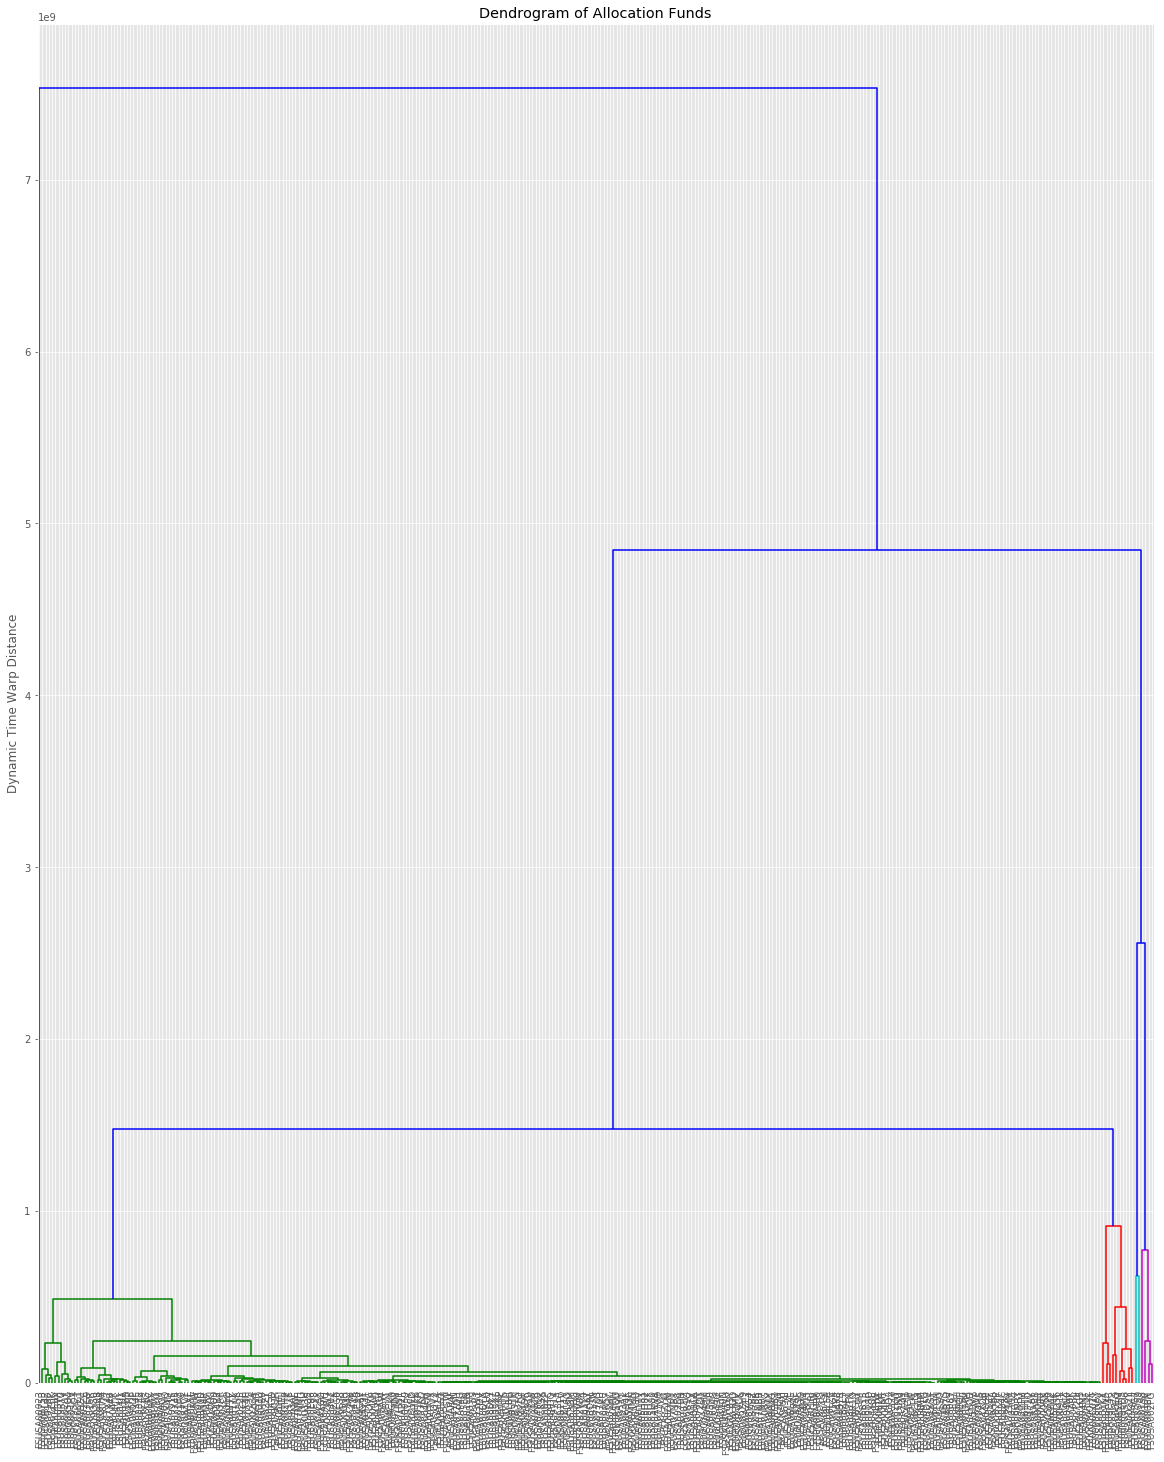

In [237]:
# Using scipy's dendrogram function plot the linkages as
# a hierachical tree.
fig, ax = plt.subplots(1,1,figsize=(20, 25))
ax.set_title('Dendrogram of Allocation Funds')
ax.set_ylabel('Dynamic Time Warp Distance')
dendro = dendrogram(link, color_threshold=1e9, leaf_font_size=9,labels=fundid_allocation['FUND_ID'].values)

In [294]:
fundid_tp = fundid[fundid['BROAD_FUND_CATEGORY']=='Tax Preferred']
data_tp = fundid_tp.iloc[:,3:27]


start = time.time()
dtw_matrix_tp = make_dtw_matrix(data_tp)
end = time.time()
dtw_tp = end - start
print(dtw_tp)

# # Pass the distance matrix into scipy's linkage function to compute our
# # hierarchical clusters.
# from scipy.cluster.hierarchy import linkage, dendrogram
# link_tp = linkage(dtw_matrix_tp, method='complete')
               
#                # Using scipy's dendrogram function plot the linkages as
# # a hierachical tree.
# fig, ax = plt.subplots(1,1,figsize=(20, 25))
# ax.set_title('Dendrogram of Tax Preferred Funds')
# ax.set_ylabel('Dynamic Time Warp Distance')
# dendro = dendrogram(link_tp, color_threshold=1e9, leaf_font_size=9,labels=fundid_tp['FUND_ID'].values)

574.3484628200531


/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


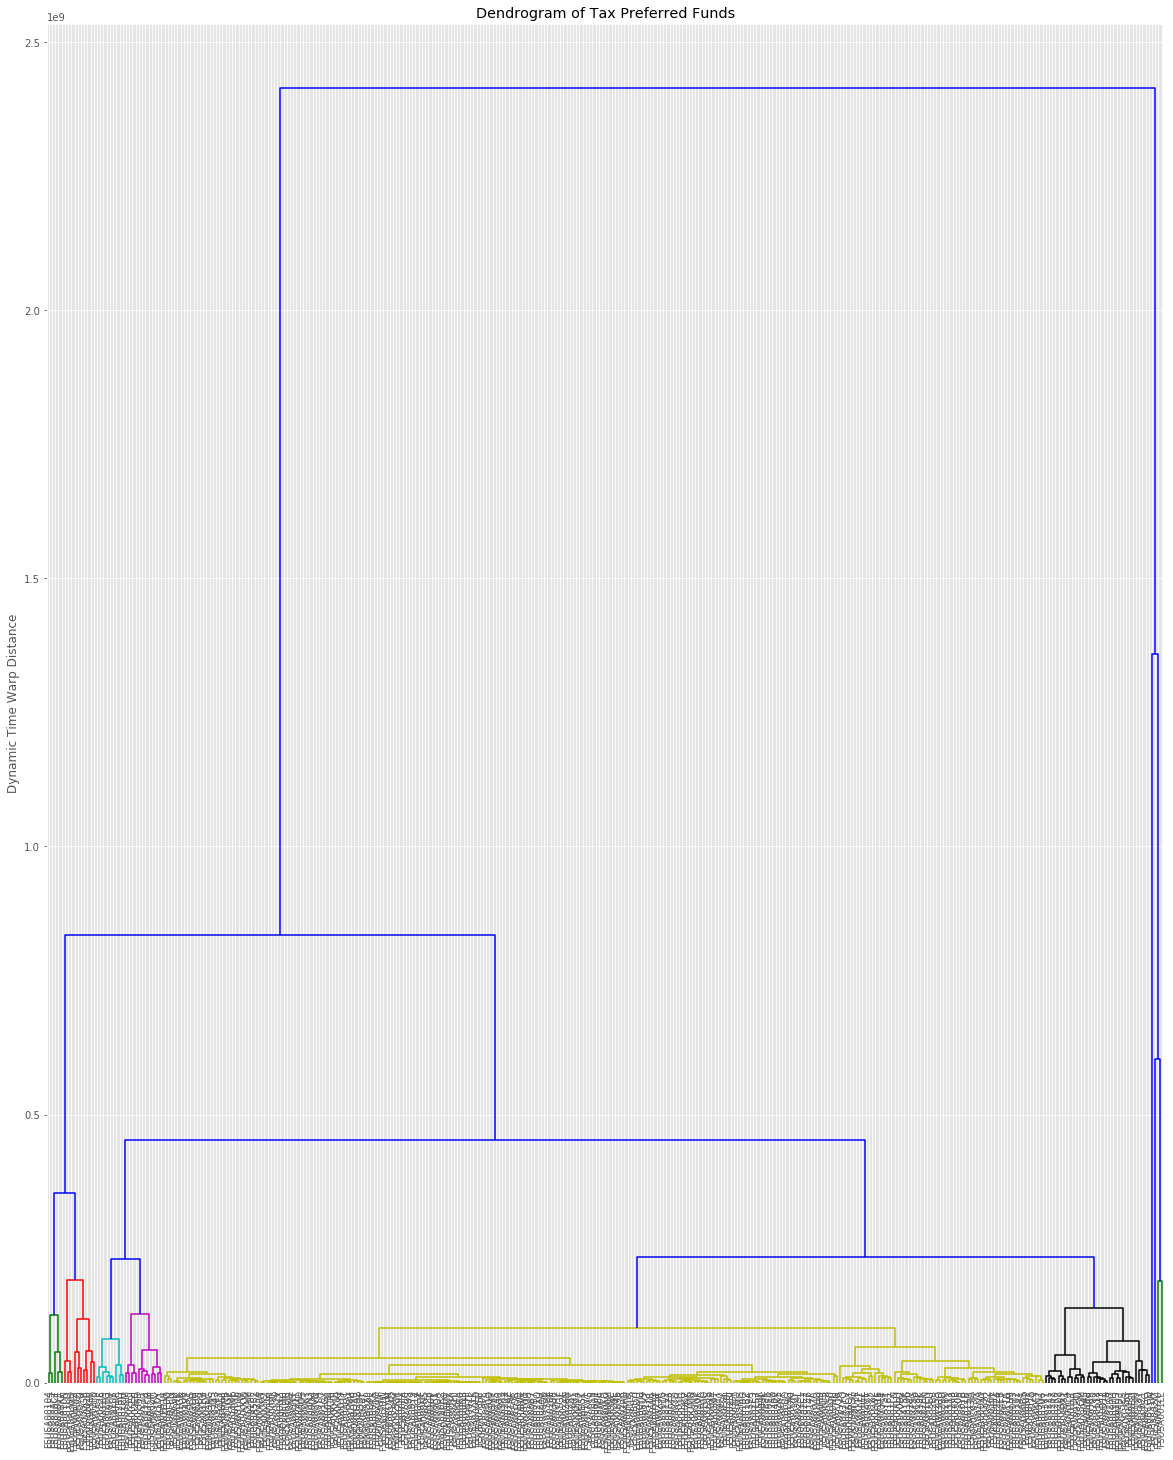

In [297]:
# Pass the distance matrix into scipy's linkage function to compute our
# hierarchical clusters.
from scipy.cluster.hierarchy import linkage, dendrogram
link_tp = linkage(dtw_matrix_tp, method='complete')
               
# Using scipy's dendrogram function plot the linkages as
# a hierachical tree.
fig, ax = plt.subplots(1,1,figsize=(20, 25))
ax.set_title('Dendrogram of Tax Preferred Funds')
ax.set_ylabel('Dynamic Time Warp Distance')
dendro = dendrogram(link_tp, color_threshold=.20e9, leaf_font_size=9,labels=fundid_tp['FUND_ID'].values)

In [312]:
max_d = 0.1e9
clusters = fcluster(link_tp, max_d, criterion='distance')
np.unique(clusters)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16], dtype=int32)

In [322]:
for cluster in range(1,17):
    df_seg=fundid_tp[fundid_tp['cluster']==cluster]
    values, counts = np.unique(df_seg['FUND_CATEGORY'],return_counts=True)
    print('Cluster {} categories:'.format(cluster))
    print('# funds in category: {}'.format(sum(counts)))
    print(list(zip(values, counts)))
    print()

Cluster 1 categories:
# funds in category: 2
[('US Fund Muni California Long', 1), ('US Fund Muni National Short', 1)]

Cluster 2 categories:
# funds in category: 3
[('US Fund Muni National Interm', 1), ('US Fund Muni National Short', 2)]

Cluster 3 categories:
# funds in category: 3
[('US Fund High Yield Muni', 1), ('US Fund Muni National Interm', 1), ('US Fund Muni National Long', 1)]

Cluster 4 categories:
# funds in category: 3
[('US Fund High Yield Muni', 1), ('US Fund Muni National Long', 1), ('US Fund Muni National Short', 1)]

Cluster 5 categories:
# funds in category: 4
[('US Fund High Yield Muni', 2), ('US Fund Muni National Interm', 1), ('US Fund Muni National Short', 1)]

Cluster 6 categories:
# funds in category: 9
[('US Fund High Yield Muni', 2), ('US Fund Muni National Interm', 3), ('US Fund Muni National Long', 2), ('US Fund Muni National Short', 2)]

Cluster 7 categories:
# funds in category: 4
[('US Fund Muni California Intermediate', 1), ('US Fund Muni National Inter

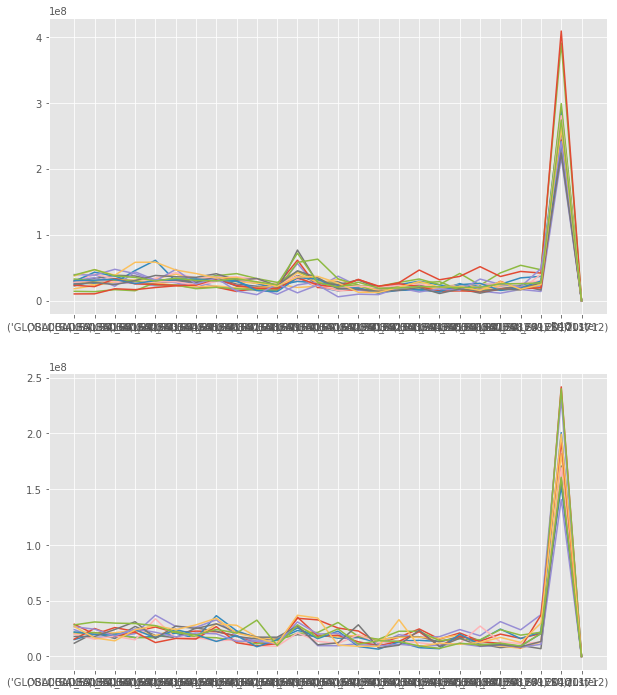

In [338]:
# plot all the funds in cluster 12
cluster12 = fundid_tp[fundid_tp['cluster']==12]
cluster11 = fundid_tp[fundid_tp['cluster']==11]
fig, ax = plt.subplots(2,1,figsize=(10,12))

for i in range(cluster12.shape[0]):
    y = cluster12.iloc[i,3:29].values
    x = cluster12.columns[3:29]
    ax[0].plot(x,y)
    
for i in range(cluster11.shape[0]):
    y = cluster11.iloc[i,3:29].values
    x = cluster11.columns[3:29]
    ax[1].plot(x,y)

In [234]:
def scree_plot(pca, title=None):
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    plt.figure(figsize=(10, 6), dpi=250)
    ax = plt.subplot(111)
    ax.bar(ind, vals, 0.35,
           color=[(0.949, 0.718, 0.004),
                  (0.898, 0.49, 0.016),
                  (0.863, 0, 0.188),
                  (0.694, 0, 0.345),
                  (0.486, 0.216, 0.541),
                  (0.204, 0.396, 0.667),
                  (0.035, 0.635, 0.459),
                  (0.486, 0.722, 0.329),
                 ])

    for i in np.arange(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    ax.set_xticklabels(ind,
                       fontsize=12)

    ax.set_ylim(0, max(vals)+0.05)
    ax.set_xlim(0-0.45, 8+0.45)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained (%)", fontsize=12)

    if title is not None:
        plt.title(title, fontsize=16)

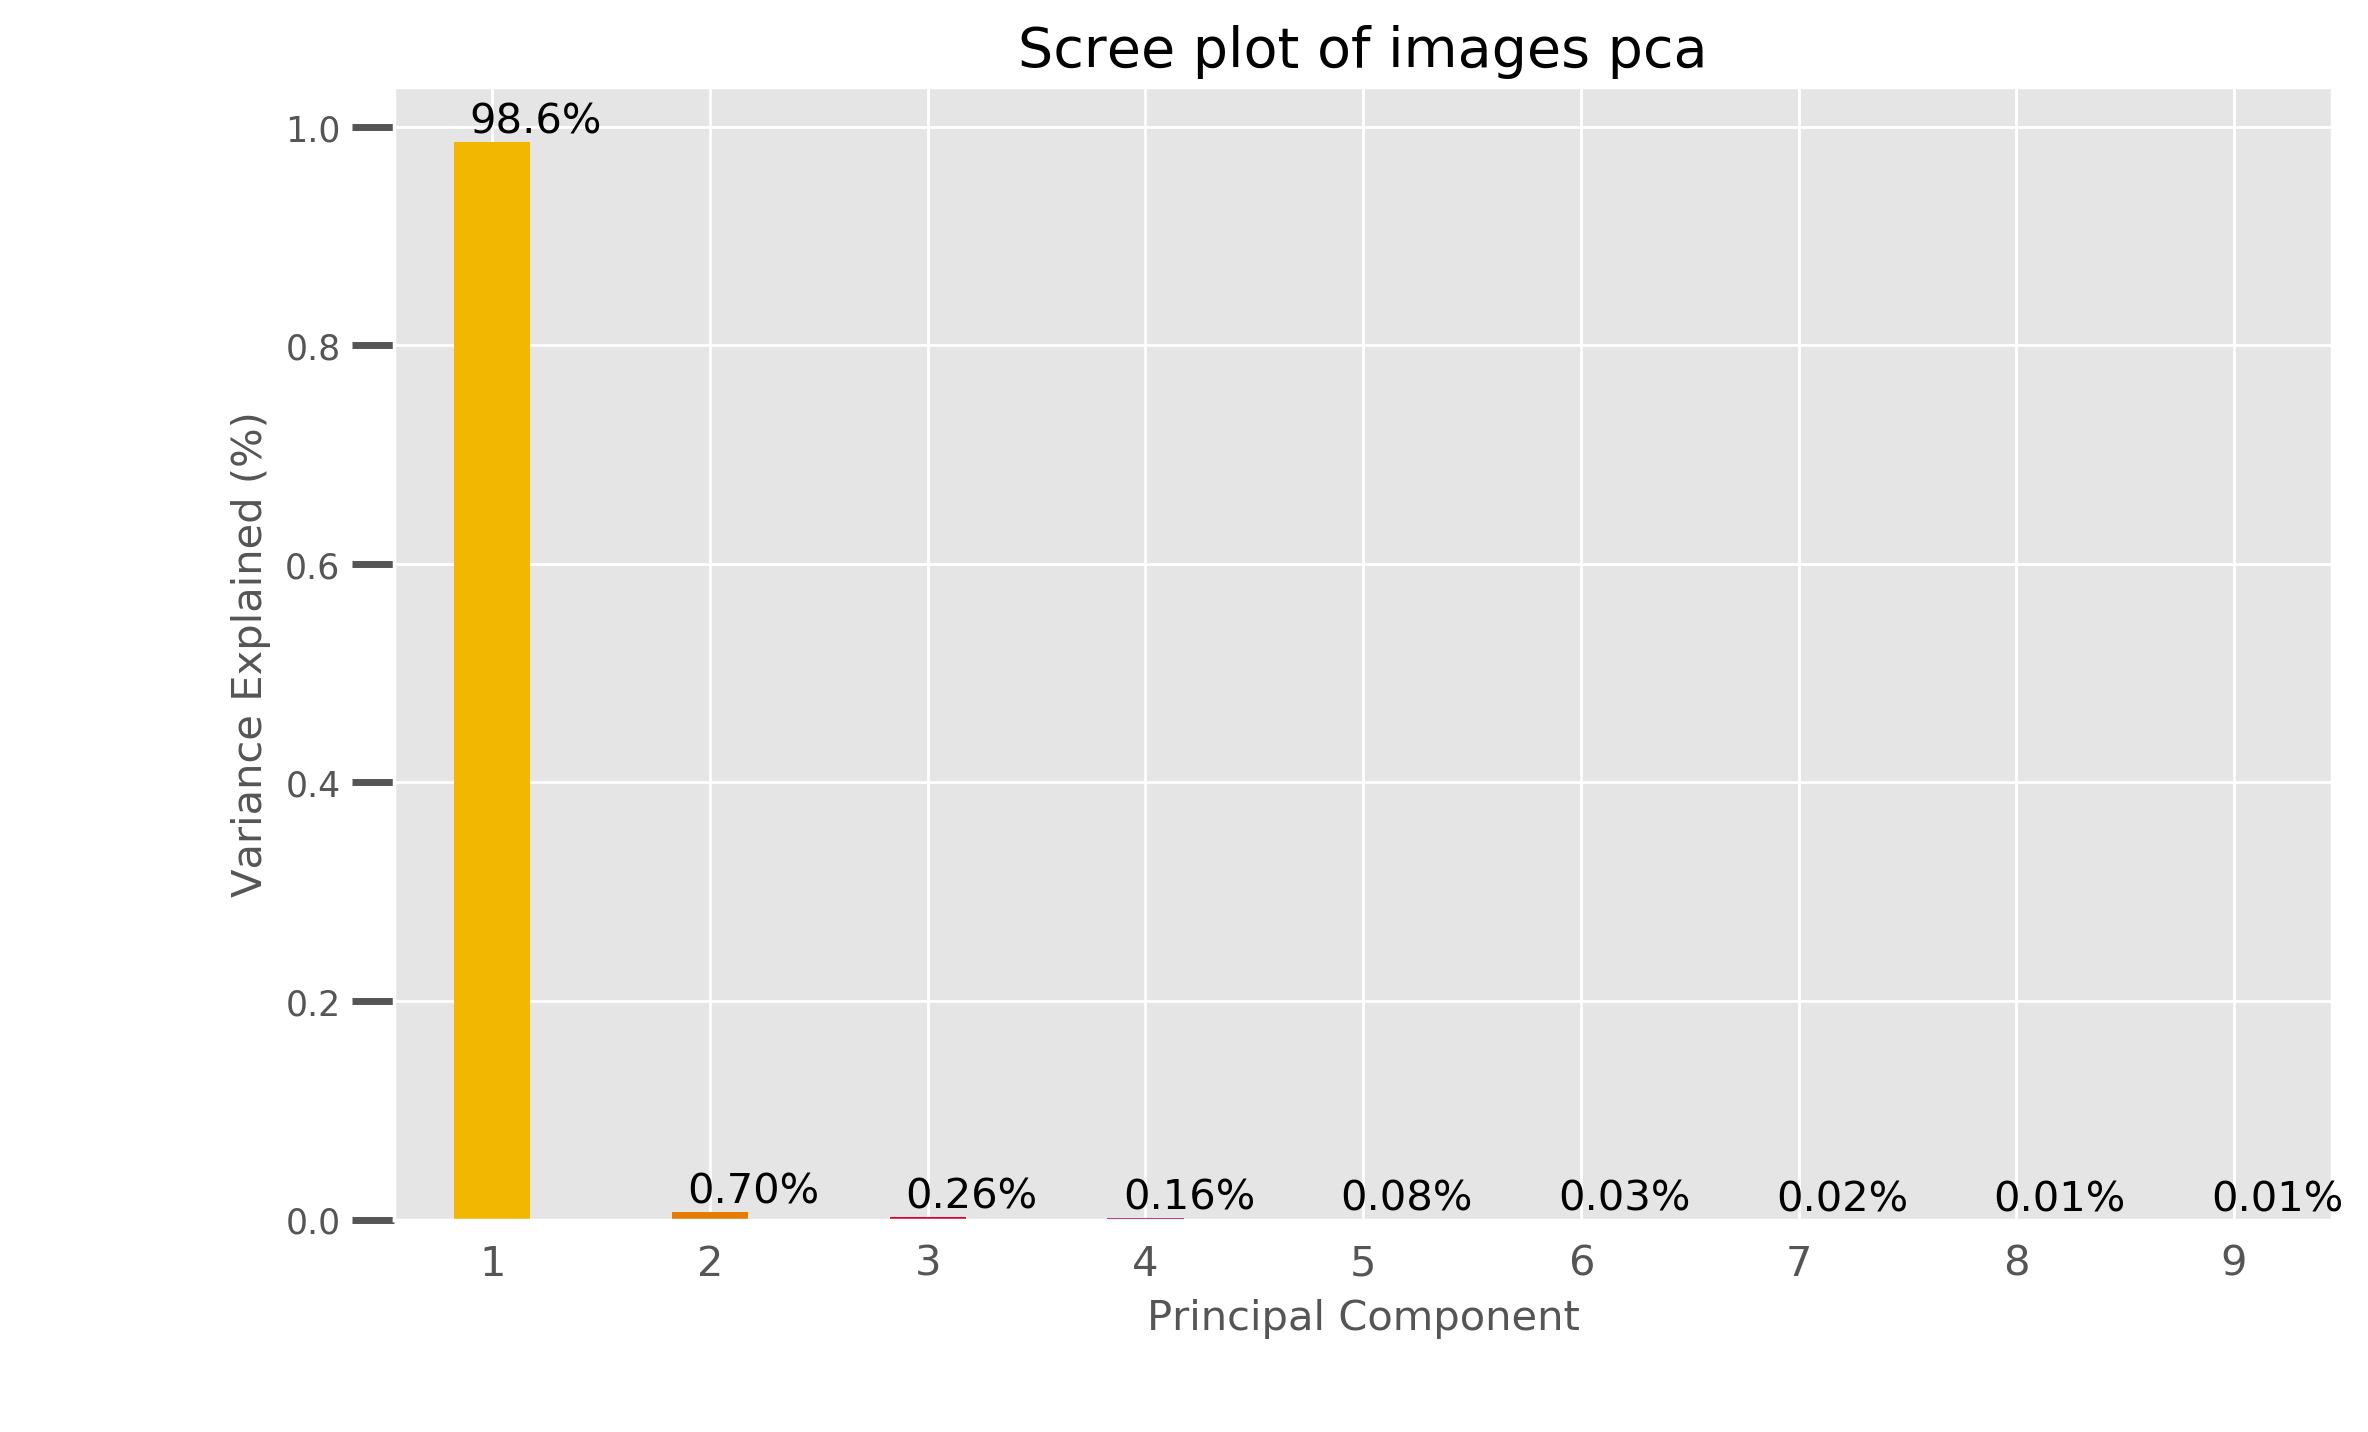

In [235]:
pca = PCA(n_components=10)
data_pca = pca.fit_transform(data)
scree_plot(pca, title = 'Scree plot of images pca')

In [256]:
tsne_5 = TSNE(n_components=2, perplexity = 5)
data_tsne5 = tsne_5.fit_transform(data)
df_tsne5 = pd.DataFrame(data_tsne5, columns = ['tsne_one','tsne_two'])

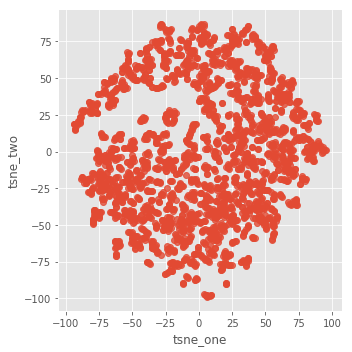

In [266]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne5 , fit_reg=False, legend=False)
plt.title='Perplexity 5'

In [268]:
tsne_10 = TSNE(n_components=2, perplexity = 10)
data_tsne10 = tsne_10.fit_transform(data)
df_tsne10 = pd.DataFrame(data_tsne10, columns = ['tsne_one','tsne_two'])

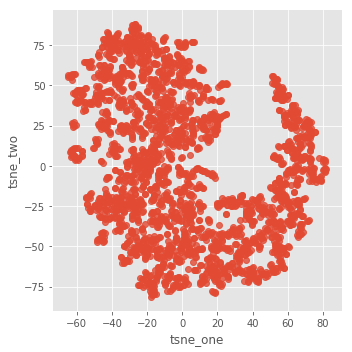

In [269]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne10 , fit_reg=False, legend=False)
plt.title='Perplexity 10'

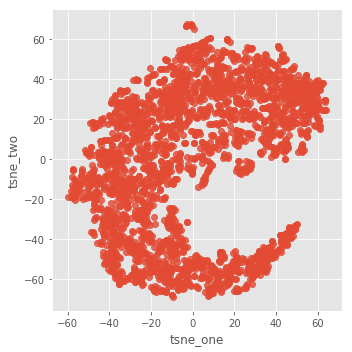

In [270]:
tsne_20 = TSNE(n_components=2, perplexity = 20)
data_tsne20 = tsne_20.fit_transform(data)
df_tsne20 = pd.DataFrame(data_tsne20, columns = ['tsne_one','tsne_two'])
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne20 , fit_reg=False, legend=False)
plt.title='Perplexity 20'

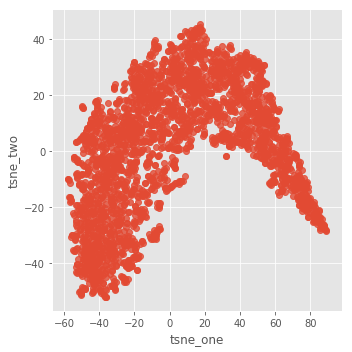

In [271]:
tsne_20 = TSNE(n_components=2, perplexity = 30)
data_tsne20 = tsne_20.fit_transform(data)
df_tsne20 = pd.DataFrame(data_tsne20, columns = ['tsne_one','tsne_two'])
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne20 , fit_reg=False, legend=False)
plt.title='Perplexity 20'

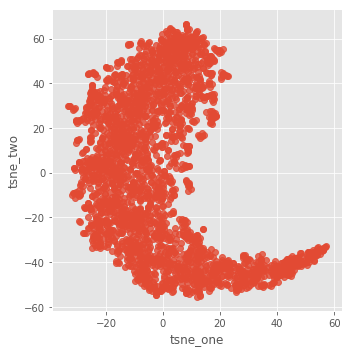

In [272]:
tsne_20 = TSNE(n_components=2, perplexity = 40)
data_tsne20 = tsne_20.fit_transform(data)
df_tsne20 = pd.DataFrame(data_tsne20, columns = ['tsne_one','tsne_two'])
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne20 , fit_reg=False, legend=False)
plt.title='Perplexity 20'

In [287]:
dbs = DBSCAN(eps=1e9)
dbs.fit(data)

DBSCAN(algorithm='auto', eps=1000000000.0, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [286]:
np.unique(dbs.labels_)

array([0])

# try:
- using 3 dims for tsne
- % diff

In [ ]:
'''
Find tsne for numerical columns
Output: assign for self.df_tsne a copy of input dataframe with
tsne columns appended
'''
tsne3 = TSNE(n_components = 3)
df_tsne3 = df_funds_sum.copy()
#use only the numeric columns
numerical_df = df_tsne3.select_dtypes(include=[np.number])

tsne_result3 = tsne3.fit_transform(numerical_df.values)


In [ ]:
df_tsne3['tsne_one'] = tsne_result3[:,0]
df_tsne3['tsne_two'] = tsne_result3[:,1]
df_tsne3['tsne_three'] = tsne_result3[:,2]
df_tsne3.head()

In [ ]:
# sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne3, hue = 'Morningstar Category', fit_reg=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
colors = df_tsne3['Morningstar Category'].values
ax.scatter(df_tsne3['tsne_one'], df_tsne3['tsne_two'], df_tsne3['tsne_three'], s=60)
ax.view_init(30, 185)
plt.show()

# convert the fund sales/reds to % change

In [ ]:
df_funds_sum.columns

In [ ]:
df_funds_sum.head()
def make_pct_change(df, list_col_names_to_change):
    '''
   
    '''
    # Filter the dataframe to just the columns to change
    df=df.copy()
    df_to_change = df.loc[:,list_col_names_to_change]
    num_columns = df_to_change.shape[1]
    
    # got through columns t+1 to end
    for col_idx in np.arange(1,num_columns):
        col_name = ('{} % Change'.format(df_to_change.iloc[:,col_idx].name))
        df[col_name]=(df_to_change.iloc[:,col_idx]-df_to_change.iloc[:,col_idx-1])/df_to_change.iloc[:,col_idx-1]
    
    return df

In [ ]:
df_funds_pct_change = make_pct_change(df_funds_sum, ['Q1 2017 SALES', 'Q2 2017 SALES','Q3 2017 SALES', 'Q4 2017 SALES'])
# drop the raw columns
df_funds_pct_change.drop(['Q1 2017 SALES', 'Q2 2017 SALES',
       'Q3 2017 SALES', 'Q4 2017 SALES', 'R4Q Total'], axis=1, inplace=True)
# deal with infinite and nan entries caused by dividing by 0 or a very small amount
df_funds_pct_change.replace([np.inf, -np.inf], np.nan, inplace=True)
df_funds_pct_change.fillna(0, inplace=True)
df_funds_pct_change.head()

In [ ]:
df_funds_pct_change.describe()

In [ ]:
tsne_pct = TSNE(n_components = 2)
df_tsne_pct = df_funds_pct_change.copy()
#use only the numeric columns
numerical_df = df_tsne_pct.select_dtypes(include=[np.number])

tsne_result_pct = tsne_pct.fit_transform(numerical_df.values)

In [ ]:
df_tsne_pct['tsne_one'] = tsne_result_pct[:,0]
df_tsne_pct['tsne_two'] = tsne_result_pct[:,1]
df_tsne_pct.head()

In [ ]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne_pct, hue = 'Morningstar Category', fit_reg=False, legend=False)

In [5]:
df_bd = df_cusip_bd.groupby(['FDS Broker Name', 'FDS Broker ID']).sum()
df_bd = df_bd.reset_index()
df_bd = df_bd[df_bd.iloc[:,-4:].sum(axis=1)>=1000000]
df_bd.head()

,FDS Broker Name,FDS Broker ID,Q1 2017 SALES,Q2 2017 SALES,Q3 2017 SALES,Q4 2017 SALES
1,1914 ADVISORS,LMS05640,4.542257e+06,4.533149e+06,3.083544e+06,3.495989e+06
2,"1ST DISCOUNT BROKERAGE, INC.",LMS00040,1.573542e+06,1.483381e+06,3.486105e+06,1.406448e+06
3,1ST GLOBAL CAPITAL CORP.,LMS00050,1.603425e+08,1.163560e+08,1.049091e+08,1.180875e+08
9,"ABACUS INVESTMENTS, INC.",LMS00290,6.319437e+05,3.562497e+05,5.026831e+05,2.847062e+05
15,ACA/PRUDENT INVESTORS PLANNING CORPORATION,LMS00410,2.709932e+06,6.552936e+05,1.283585e+06,1.257478e+06


In [6]:
tsne_bd = TSNE(n_components = 2)
df_tsne_bd = df_bd.copy()
#use only the numeric columns
numerical_df = df_bd.select_dtypes(include=[np.number])
tsne_result_bd = tsne_bd.fit_transform(numerical_df.values)

In [7]:
df_tsne_bd['tsne_one'] = tsne_result_bd[:,0]
df_tsne_bd['tsne_two'] = tsne_result_bd[:,1]
df_tsne_bd.head()

,FDS Broker Name,FDS Broker ID,Q1 2017 SALES,Q2 2017 SALES,Q3 2017 SALES,Q4 2017 SALES,tsne_one,tsne_two
1,1914 ADVISORS,LMS05640,4.542257e+06,4.533149e+06,3.083544e+06,3.495989e+06,-3.305495,15.003006
2,"1ST DISCOUNT BROKERAGE, INC.",LMS00040,1.573542e+06,1.483381e+06,3.486105e+06,1.406448e+06,7.578774,1.502201
3,1ST GLOBAL CAPITAL CORP.,LMS00050,1.603425e+08,1.163560e+08,1.049091e+08,1.180875e+08,-30.997513,-28.672800
9,"ABACUS INVESTMENTS, INC.",LMS00290,6.319437e+05,3.562497e+05,5.026831e+05,2.847062e+05,42.011662,-5.913361
15,ACA/PRUDENT INVESTORS PLANNING CORPORATION,LMS00410,2.709932e+06,6.552936e+05,1.283585e+06,1.257478e+06,18.772490,1.282723


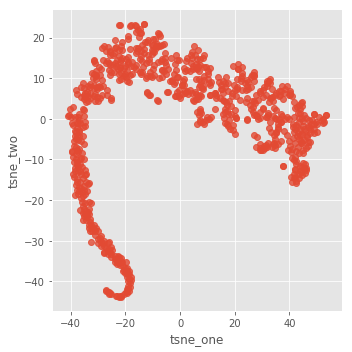

In [8]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne_bd, fit_reg=False, legend=False)

In [60]:
# df_bd_mstar_Q4 = 
df_bd_mstar = df_cusip_bd_fundid.groupby(['FDS Broker Name','FDS Broker ID', 'Morningstar Category']).sum()
df_bd_mstar = df_bd_mstar.reset_index()
df_bd_mstar.drop('Rating', axis=1, inplace=True)
df_bd_mstar.head()

df_bd_mstar2 = pd.pivot_table(df_bd_mstar, index=['FDS Broker Name','FDS Broker ID'], \
                              values = 'Q4 2017 SALES', fill_value=0,columns = 'Morningstar Category',\
                              aggfunc = 'sum')
df_bd_mstar2 = df_bd_mstar2.reset_index()
df_bd_mstar2.head()


Morningstar Category,FDS Broker Name,FDS Broker ID,US Fund Allocation--15% to 30% Equity,US Fund Allocation--30% to 50% Equity,US Fund Allocation--50% to 70% Equity,US Fund Allocation--70% to 85% Equity,US Fund Allocation--85%+ Equity,US Fund Bank Loan,US Fund Bear Market,US Fund China Region,US Fund Commodities Broad Basket,US Fund Communications,US Fund Consumer Cyclical,US Fund Consumer Defensive,US Fund Convertibles,US Fund Corporate Bond,US Fund Diversified Emerging Mkts,US Fund Diversified Pacific/Asia,US Fund Emerging Markets Bond,US Fund Emerging-Markets Local-Currency Bond,US Fund Energy Limited Partnership,US Fund Equity Energy,US Fund Equity Precious Metals,US Fund Europe Stock,US Fund Financial,US Fund Foreign Large Blend,US Fund Foreign Large Growth,US Fund Foreign Large Value,US Fund Foreign Small/Mid Blend,US Fund Foreign Small/Mid Growth,US Fund Foreign Small/Mid Value,US Fund Global Real Estate,US Fund Health,US Fund High Yield Bond,US Fund High Yield Muni,US Fund India Equity,US Fund Industrials,US Fund Inflation-Protected Bond,US Fund Infrastructure,US Fund Intermediate Government,US Fund Intermediate-Term Bond,US Fund Japan Stock,US Fund Large Blend,US Fund Large Growth,US Fund Large Value,US Fund Latin America Stock,US Fund Long Government,US Fund Long-Short Credit,US Fund Long-Short Equity,US Fund Long-Term Bond,US Fund Managed Futures,US Fund Market Neutral,US Fund Mid-Cap Blend,US Fund Mid-Cap Growth,US Fund Mid-Cap Value,US Fund Miscellaneous Region,US Fund Multialternative,US Fund Multicurrency,US Fund Multisector Bond,US Fund Muni California Intermediate,US Fund Muni California Long,US Fund Muni Massachusetts,US Fund Muni Minnesota,US Fund Muni National Interm,US Fund Muni National Long,US Fund Muni National Short,US Fund Muni New Jersey,US Fund Muni New York Intermediate,US Fund Muni New York Long,US Fund Muni Ohio,US Fund Muni Pennsylvania,US Fund Muni Single State Interm,US Fund Muni Single State Long,US Fund Muni Single State Short,US Fund Natural Resources,US Fund Nontraditional Bond,US Fund Options-based,US Fund Pacific/Asia ex-Japan Stk,US Fund Preferred Stock,US Fund Real Estate,US Fund Short Government,US Fund Short-Term Bond,US Fund Small Blend,US Fund Small Growth,US Fund Small Value,US Fund Tactical Allocation,US Fund Target-Date 2000-2010,US Fund Target-Date 2015,US Fund Target-Date 2020,US Fund Target-Date 2025,US Fund Target-Date 2030,US Fund Target-Date 2035,US Fund Target-Date 2040,US Fund Target-Date 2045,US Fund Target-Date 2050,US Fund Target-Date 2055,US Fund Target-Date 2060+,US Fund Target-Date Retirement,US Fund Technology,US Fund Ultrashort Bond,US Fund Utilities,US Fund World Allocation,US Fund World Bond,US Fund World Large Stock,US Fund World Small/Mid Stock
0,1717 CAPITAL MANAGEMENT COMPANY,LMS58260,0.00,0.00,225.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,1833.44,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,420.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,300.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,420.00,480.00,360.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,480.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1914 ADVISORS,LMS05640,0.00,15000.00,27330.66,6981.61,0.00,0.0,0.0,0.0,390.18,0.00,0.0,0,0.0,22514.90,57039.72,0.0,25678.98,0.00,14095.00,0.00,3297.96,0.00,0.0,22909.72,124978.75,0.00,0.0,0.00,0.0,172.42,0.00,91610.48,164567.0,0.0,0.0,0.00,0.0,0.0,4656.57,0.0,409754.20,198256.18,270782.51,0.0,0.0,0.0,333524.59,0.0,0.0,0.0,695.14,0.00,76150.00,0.0,0.00,0.0,425505.65,0.0,0.00,0.0,0.0,190000.00,95000.00,20000.00,0.0,0.0,0.0,0.0,111594.88,0.0,0.0,0.0,0.00,263500.0,0.0,0.0,46150.0,57941.75,0.00,16741.04,10000.00,25695.13,10618.72,69900.00,0.00,394.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,427.34,0.00,0.0,5000.00,2256.97,0.00,155977.00,955.20,79783.99,38159.83
2,"1ST DISCOUNT BROKERAGE, INC.",LMS00040,0

In [61]:
tsne_bd_mstar = TSNE(n_components = 2)
df_tsne_bd_mstar = df_bd_mstar2.copy()
#use only the numeric columns
numerical_df = df_bd_mstar2.select_dtypes(include=[np.number])
tsne_result_bd_mstar = tsne_bd_mstar.fit_transform(numerical_df.values)

df_tsne_bd_mstar['tsne_one'] = tsne_result_bd_mstar[:,0]
df_tsne_bd_mstar['tsne_two'] = tsne_result_bd_mstar[:,1]
df_tsne_bd_mstar.head()

Morningstar Category,FDS Broker Name,FDS Broker ID,US Fund Allocation--15% to 30% Equity,US Fund Allocation--30% to 50% Equity,US Fund Allocation--50% to 70% Equity,US Fund Allocation--70% to 85% Equity,US Fund Allocation--85%+ Equity,US Fund Bank Loan,US Fund Bear Market,US Fund China Region,US Fund Commodities Broad Basket,US Fund Communications,US Fund Consumer Cyclical,US Fund Consumer Defensive,US Fund Convertibles,US Fund Corporate Bond,US Fund Diversified Emerging Mkts,US Fund Diversified Pacific/Asia,US Fund Emerging Markets Bond,US Fund Emerging-Markets Local-Currency Bond,US Fund Energy Limited Partnership,US Fund Equity Energy,US Fund Equity Precious Metals,US Fund Europe Stock,US Fund Financial,US Fund Foreign Large Blend,US Fund Foreign Large Growth,US Fund Foreign Large Value,US Fund Foreign Small/Mid Blend,US Fund Foreign Small/Mid Growth,US Fund Foreign Small/Mid Value,US Fund Global Real Estate,US Fund Health,US Fund High Yield Bond,US Fund High Yield Muni,US Fund India Equity,US Fund Industrials,US Fund Inflation-Protected Bond,US Fund Infrastructure,US Fund Intermediate Government,US Fund Intermediate-Term Bond,US Fund Japan Stock,US Fund Large Blend,US Fund Large Growth,US Fund Large Value,US Fund Latin America Stock,US Fund Long Government,US Fund Long-Short Credit,US Fund Long-Short Equity,US Fund Long-Term Bond,US Fund Managed Futures,US Fund Market Neutral,US Fund Mid-Cap Blend,US Fund Mid-Cap Growth,US Fund Mid-Cap Value,US Fund Miscellaneous Region,US Fund Multialternative,US Fund Multicurrency,US Fund Multisector Bond,US Fund Muni California Intermediate,US Fund Muni California Long,US Fund Muni Massachusetts,US Fund Muni Minnesota,US Fund Muni National Interm,US Fund Muni National Long,US Fund Muni National Short,US Fund Muni New Jersey,US Fund Muni New York Intermediate,US Fund Muni New York Long,US Fund Muni Ohio,US Fund Muni Pennsylvania,US Fund Muni Single State Interm,US Fund Muni Single State Long,US Fund Muni Single State Short,US Fund Natural Resources,US Fund Nontraditional Bond,US Fund Options-based,US Fund Pacific/Asia ex-Japan Stk,US Fund Preferred Stock,US Fund Real Estate,US Fund Short Government,US Fund Short-Term Bond,US Fund Small Blend,US Fund Small Growth,US Fund Small Value,US Fund Tactical Allocation,US Fund Target-Date 2000-2010,US Fund Target-Date 2015,US Fund Target-Date 2020,US Fund Target-Date 2025,US Fund Target-Date 2030,US Fund Target-Date 2035,US Fund Target-Date 2040,US Fund Target-Date 2045,US Fund Target-Date 2050,US Fund Target-Date 2055,US Fund Target-Date 2060+,US Fund Target-Date Retirement,US Fund Technology,US Fund Ultrashort Bond,US Fund Utilities,US Fund World Allocation,US Fund World Bond,US Fund World Large Stock,US Fund World Small/Mid Stock,tsne_one,tsne_two
0,1717 CAPITAL MANAGEMENT COMPANY,LMS58260,0.00,0.00,225.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,1833.44,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,420.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,300.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,420.00,480.00,360.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,480.00,0.00,0.00,0.00,0.00,0.00,0.00,15.110941,-12.256586
1,1914 ADVISORS,LMS05640,0.00,15000.00,27330.66,6981.61,0.00,0.0,0.0,0.0,390.18,0.00,0.0,0,0.0,22514.90,57039.72,0.0,25678.98,0.00,14095.00,0.00,3297.96,0.00,0.0,22909.72,124978.75,0.00,0.0,0.00,0.0,172.42,0.00,91610.48,164567.0,0.0,0.0,0.00,0.0,0.0,4656.57,0.0,409754.20,198256.18,270782.51,0.0,0.0,0.0,333524.59,0.0,0.0,0.0,695.14,0.00,76150.00,0.0,0.00,0.0,425505.65,0.0,0.00,0.0,0.0,190000.00,95000.00,20000.00,0.0,0.0,0.0,0.0,111594.88,0.0,0.0,0.0,0.00,263500.0,0.0,0.0,46150.0,57941.75,0.00,16741.04,10000.00,25695.13,10618.72,69900.00,0.00,394.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,427.34,0.00,0.0,5000.00,2256.97,0.00,155977.00,955.20,79783.99,38159.83,4.42

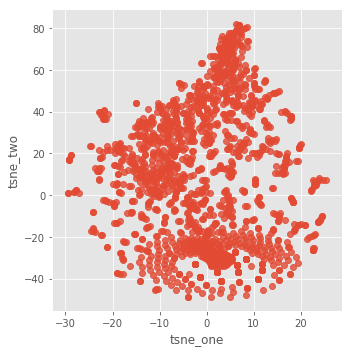

In [62]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne_bd_mstar, fit_reg=False)

In [ ]:
# Try to take out the time component

In [ ]:
# try clustering in high-dimensional space.
# feature engineer so that jan fun 1- avg jan all funds
# dynamic time warping - use dtw as the distance metric hierachical clustering lecture
# 

# Results day 1
data processing minimal Nan->0
pca - no pattern
tsne - warpy thing, mostly picking up on time?

tried:
    - 3 component tsne: no better
    - % diff QoQ: no better
    
  goals: remove the time cycle component